In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of skaro, before pip installed version, for debugging
import os
import pathlib
import sys

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yt
from matplotlib.ticker import ScalarFormatter

from skaro.analysis import count_planets
from skaro.model import Model
from skaro.utilities.dataframe import (
    rename_labels,
    rename_entries,
    aggregated_dataframe,
)
from skaro.utilities.math import calculate_pca
from skaro.visualization.visualization_utils import (
    FigureProcessor,
    adjust_legend,
    get_palette,
    ridgeplot,
    set_plot_defaults,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"
num_embryos = 50
host_star_masses = 1
planet_categories = [
    "Earth",
    "Super-Earth",
    "Neptunian",
    "Sub-Giant",
    "Giant",
]

In [5]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo


      DETECTED LOCAL MACHINE: Test snapshot loaded.


      CONFIG: Setting resolution to 4096.


      CONFIG: Setting sim_id to 09_18.



yt : [INFO     ] 2024-02-08 13:19:19,648 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2024-02-08 13:19:19,811 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2024-02-08 13:19:19,812 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-02-08 13:19:19,813 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-02-08 13:19:19,814 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2024-02-08 13:19:19,815 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-08 13:19:19,816 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2024-02-08 13:19:19,816 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2024-02-08 13:19:19,817 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2024-02-08 13:19:19,817 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-02-08 13:19:19,818 Parameters: hubble_constant   

## PLOT SETUP

In [6]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Component_populations"
save = True

## CREATE DATASOURCE

In [7]:
radius = 0.2 * mw.virial_radius()
masses = (0.3, 0.5, 1)
components = ["Bulge", "Thin Disk", "Thick Disk", "Halo"]

sphere = mw.sphere(radius=radius)

## PLANET AGES PER COMPONENT

In [8]:
data = aggregated_dataframe(
    ["bulge_stars", "thin_disk_stars", "thick_disk_stars", "halo_stars"],
    ["stellar_age", *planet_categories],
    data_source=sphere,
    type_name="Component",
    custom_units={"stellar_age": "Gyr"},
)
data = rename_entries(data)

In [22]:
# average planet age
data.groupby("Component").apply(
    lambda x: np.average(
        x["stellar_age"],
        weights=sum([x[type] for type in planet_categories]),
    ),
    include_groups=False,
).round(decimals=1)

Component
Bulge         6.3
Halo          6.1
Thick Disk    6.3
Thin Disk     3.2
dtype: float64

In [24]:
# planet age per type
planet_ages = pd.DataFrame(
    [
        data.groupby("Component").apply(
            lambda x: np.average(
                x["stellar_age"],
                weights=x[type],
            ),
            include_groups=False,
        )
        for type in planet_categories
    ],
    index=planet_categories,
).T
planet_ages.round(decimals=1)

,Earth,Super-Earth,Neptunian,Sub-Giant,Giant
Component,,,,,
Bulge,6.8,6.1,5.1,5.0,4.4
Halo,6.3,5.9,5.4,5.1,4.9
Thick Disk,6.4,6.2,6.0,6.0,5.6
Thin Disk,3.5,3.1,2.7,2.6,2.5


## OCCURENCE RATES PER COMPONENT

In [11]:
occurence_rate_dataframe = {}
for m in masses:
    occurence_rate_dataframe[m] = count_planets(
        model,
        lambda: mw.sphere(radius=radius),
        planet_categories,
        normalize_by="planet_hosting_number",
        model_config={"ngpps_star_masses": m},
        long_format=False,
        value_name="Occurence Rate",
    )

occurence_rate_long_format = {
    m: occurence_rate_dataframe[m].melt(
        id_vars="Component",
        var_name="Planet Type",
        value_name="Occurence Rate",
    )
    for m in masses
}


      CONFIG: Setting ngpps_star_masses to 0.3.




      TIMER: Block 'Adding Planets...' took 1.71 seconds.


      CONFIG: Setting ngpps_star_masses to 0.5.


      TIMER: Block 'Adding Planets...' took 1.7 seconds.


      CONFIG: Setting ngpps_star_masses to 1.


      TIMER: Block 'Adding Planets...' took 1.75 seconds.



/tmp/ipykernel_23174/4179524514.py:4: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  occurence_rate_barplot = sns.barplot(
/tmp/ipykernel_23174/4179524514.py:4: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  occurence_rate_barplot = sns.barplot(
/tmp/ipykernel_23174/4179524514.py:4: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  occurence_rate_barplot = sns.barplot(


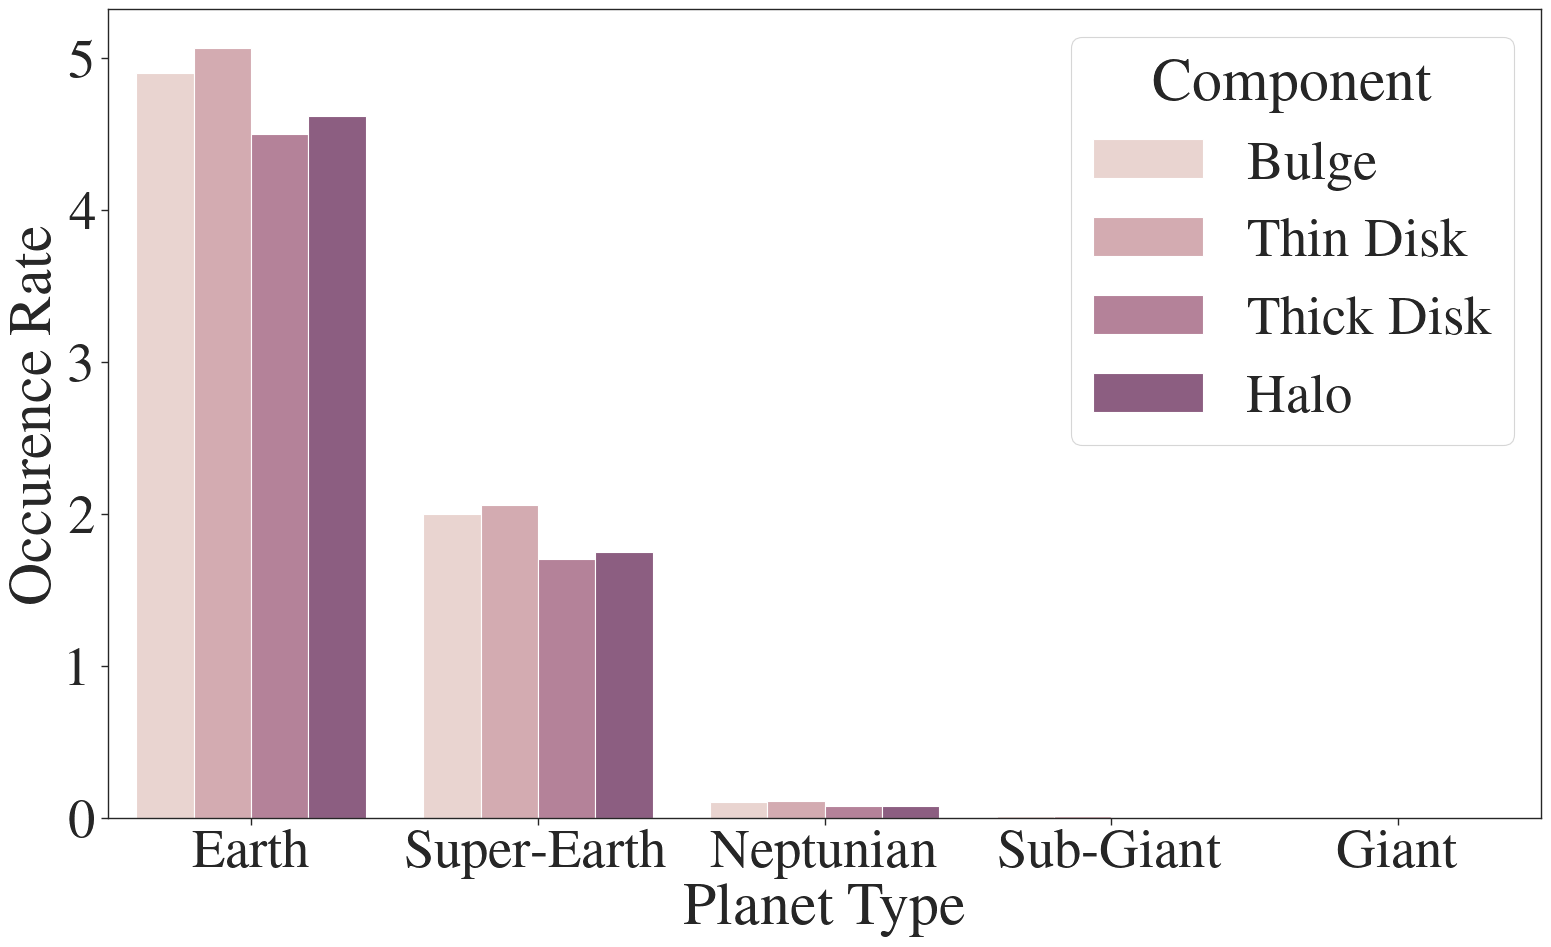

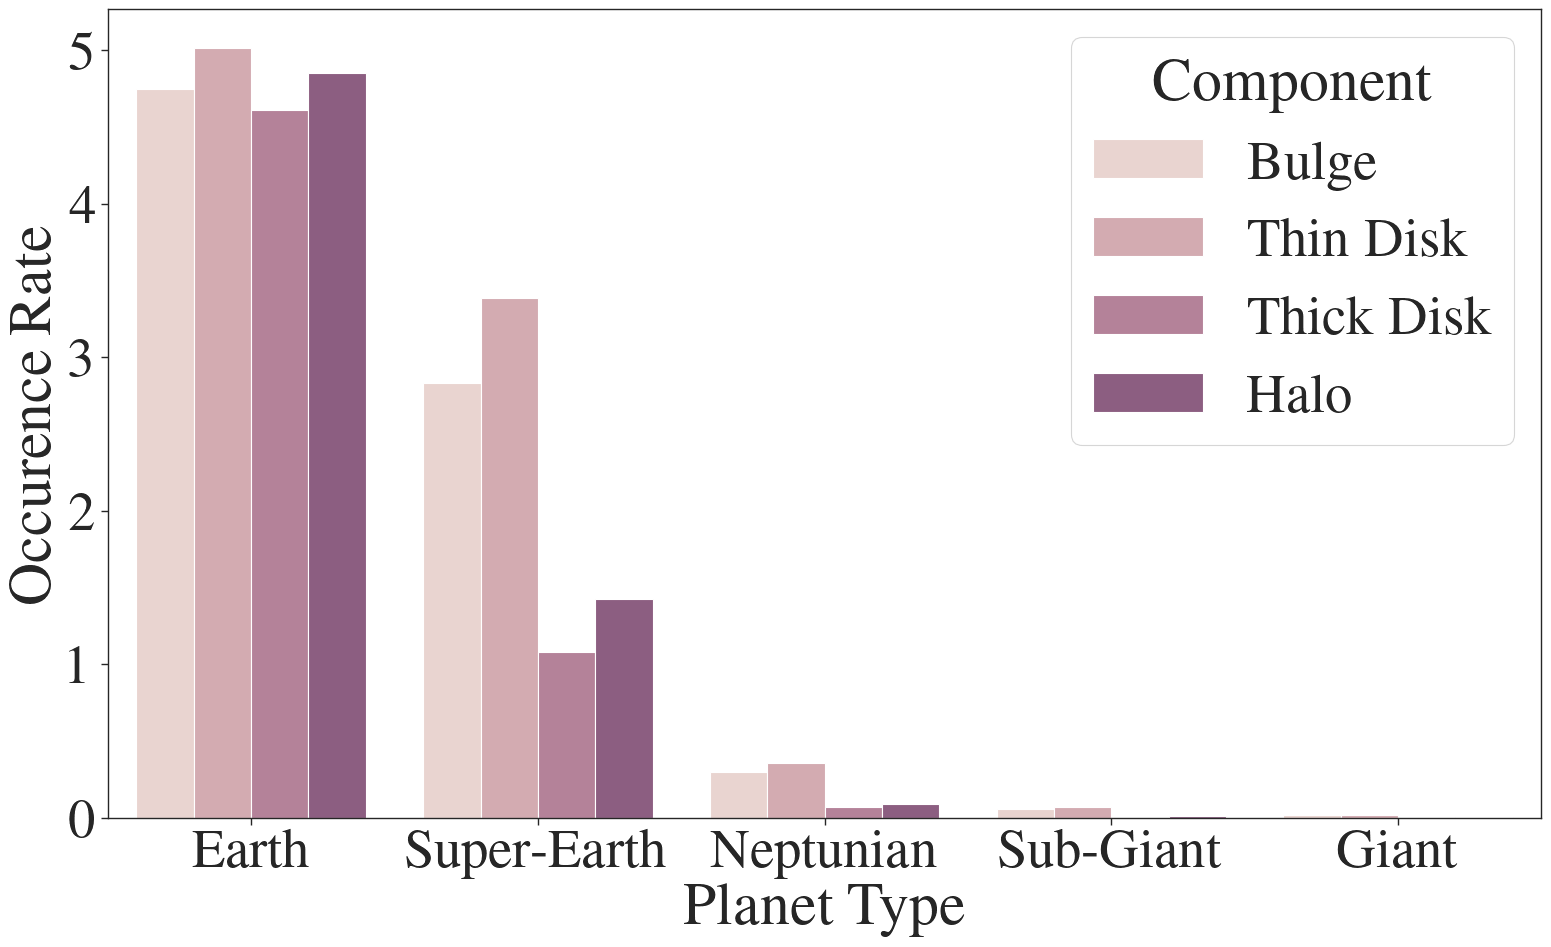

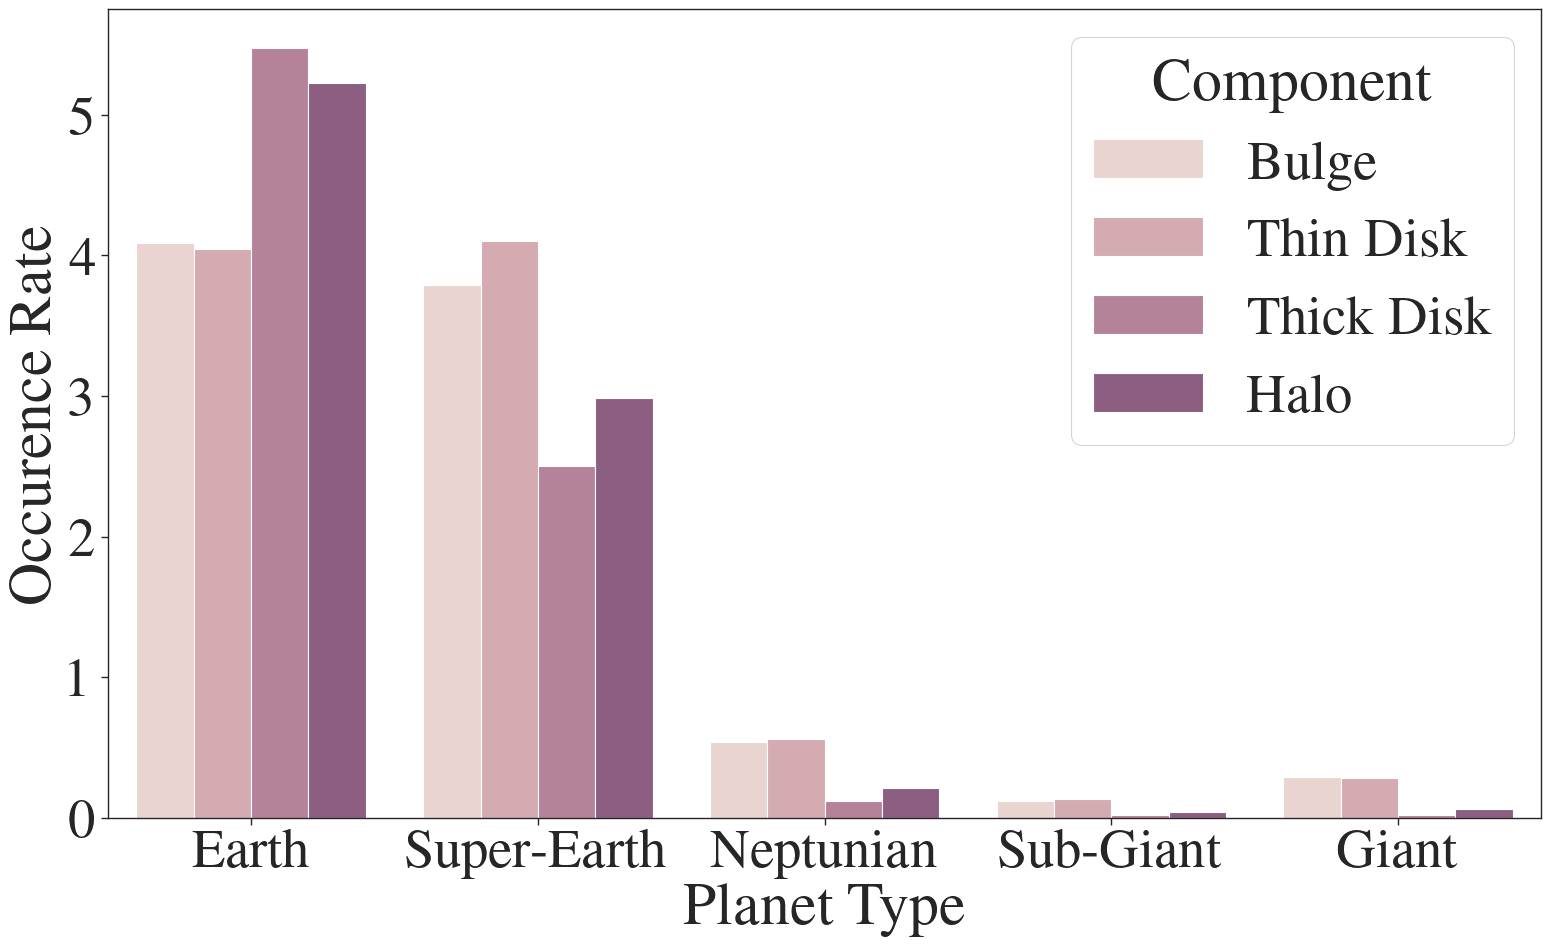

In [27]:
def barplot(occurence_rate_long_format, host_star_mass):
    plt.figure()
    with sns.axes_style("ticks"):
        occurence_rate_barplot = sns.barplot(
            data=occurence_rate_long_format,
            x="Planet Type",
            y="Occurence Rate",
            hue="Component",
            hue_order=components,
            # log=True,
            palette=get_palette(),
        )

    FigureProcessor(occurence_rate_barplot.figure).save(
        f"occurence_rates_with_host_star_mass={host_star_mass}.pdf",
        sub_directory=figure_subdirectory,
        save=save,
    )
    return occurence_rate_barplot


for m in masses:
    plot = barplot(occurence_rate_long_format[m], host_star_mass=m)

In [28]:
occurence_rate_combined = {}

for key, value in occurence_rate_dataframe.items():
    dataframe = value.copy()

    # transpose dataframe
    dataframe.set_index("Component", inplace=True)
    dataframe.index.name = None
    dataframe = dataframe.T

    dataframe = dataframe[components]  # reorder columns

    occurence_rate_combined[key] = dataframe

In [29]:
pd.concat(occurence_rate_combined, names=[r"$M_\star$"]).round(decimals=3)

Bulge  Thin Disk  Thick Disk   Halo
$M_\star$                                                 
0.3       Earth        4.904      5.068       4.498  4.617
          Super-Earth  1.997      2.061       1.701  1.751
          Neptunian    0.102      0.109       0.074  0.079
          Sub-Giant    0.014      0.014       0.003  0.004
          Giant        0.000      0.000       0.000  0.000
0.5       Earth        4.744      5.015       4.609  4.853
          Super-Earth  2.831      3.382       1.080  1.424
          Neptunian    0.299      0.355       0.070  0.092
          Sub-Giant    0.060      0.067       0.004  0.010
          Giant        0.016      0.018       0.002  0.004
1.0       Earth        4.088      4.045       5.476  5.222
          Super-Earth  3.788      4.101       2.502  2.989
          Neptunian    0.536      0.561       0.121  0.210
          Sub-Giant    0.120      0.131       0.016  0.039
          Giant        0.287      0.286       0.018  0.062